### 1. Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler,label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split,cross_validate, cross_val_score,KFold,RandomizedSearchCV,StratifiedKFold,GridSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression,LinearRegression, Ridge, Lasso
from sklearn.metrics import (confusion_matrix, classification_report,auc,roc_auc_score,roc_curve,silhouette_samples,silhouette_score,accuracy_score, mean_squared_error, r2_score,mean_absolute_error)
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.feature_selection import chi2, SelectKBest,RFE,f_classif
from scipy.stats import chi2_contingency,pearsonr
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,pairwise_distances
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from sklearn.cluster import AgglomerativeClustering
from kmodes.kmodes import KModes
from datetime import datetime
from sklearn.neighbors import NearestNeighbors
import warnings; warnings.filterwarnings("ignore")

### 2. Descriptive Analytics

#### 2.1 Load Dataset

In [2]:
data = pd.read_csv('Census.csv')

In [3]:
data.head(5)

,Person ID,Region,Residence Type,Family Composition,Population Base,Sex,Age,Marital Status,Student,Country of Birth,Health,Ethnic Group,Religion,Economic Activity,Occupation,Industry,Hours worked per week,No of hours,Approximated Social Grade
0,7394816,E12000001,H,2,1,2,6,2,2,1,2,1,2,5,8,2,-9,NaN,4
1,7394832,E12000001,H,3,1,2,1,1,2,1,2,1,1,-9,-9,-9,-9,NaN,-9
2,7394719,E12000001,H,2,1,1,7,2,2,1,1,1,2,5,8,2,-9,NaN,2
3,7394840,E12000001,H,1,1,2,6,4,2,1,3,1,2,5,9,5,-9,NaN,4
4,7394711,E12000001,H,2,1,1,1,1,1,1,1,1,1,-9,-9,-9,-9,NaN,-9


In [4]:
data.shape

(569740, 19)

<font color="green">* This shows that the DataFrame has 569,740 rows and 19 columns.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569740 entries, 0 to 569739
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Person ID                  569740 non-null  int64  
 1   Region                     569740 non-null  object 
 2   Residence Type             569740 non-null  object 
 3   Family Composition         569740 non-null  int64  
 4   Population Base            569740 non-null  int64  
 5   Sex                        569740 non-null  int64  
 6   Age                        569740 non-null  int64  
 7   Marital Status             569740 non-null  int64  
 8   Student                    569740 non-null  int64  
 9   Country of Birth           569740 non-null  int64  
 10  Health                     569740 non-null  int64  
 11  Ethnic Group               569740 non-null  int64  
 12  Religion                   569740 non-null  int64  
 13  Economic Activity          56

### 3. Data Cleaning/Preparation

#### 3.1 Null Check in Data

In [6]:
data.isnull().sum()

Person ID                         0
Region                            0
Residence Type                    0
Family Composition                0
Population Base                   0
Sex                               0
Age                               0
Marital Status                    0
Student                           0
Country of Birth                  0
Health                            0
Ethnic Group                      0
Religion                          0
Economic Activity                 0
Occupation                        0
Industry                          0
Hours worked per week             0
No of hours                  302321
Approximated Social Grade         0
dtype: int64

<font color="green"> *'No of hours' column has 302,321 missing values, while all other columns have no missing values (0 missing).*

#### 3.2 Check Duplicates

In [7]:
duplicates = data[data.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [Person ID, Region, Residence Type, Family Composition, Population Base, Sex, Age, Marital Status, Student, Country of Birth, Health, Ethnic Group, Religion, Economic Activity, Occupation, Industry, Hours worked per week, No of hours, Approximated Social Grade]
Index: []


<font color="green"> *There are no duplicates in the data.*

#### 3.3 Data Imputation

In [8]:
#Fill missing values in 'No of Hours' with the mean
df = data.copy()
df['No of hours'].fillna(df['No of hours'].mean(), inplace=True)

#### 3.4 Data Transformation

In [9]:
#Drop Unneccesary Columns
df1 = df.drop('Person ID', axis=1)

In [10]:
#Categorize the Columns for Better Understandings
# Mapping for the Sex column
sex_mapping = {1: 'Male', 2: 'Female'}
df1['Sex'] = df1['Sex'].replace(sex_mapping)

# Mapping for the Region column
region_mapping = {
    'E12000001': 'North_East', 'E12000002': 'North_West', 'E12000003': 'Yorkshire_Humber',
    'E12000004': 'East_Midlands', 'E12000005': 'West_Midlands', 'E12000006': 'East_England',
    'E12000007': 'London', 'E12000008': 'South_East', 'E12000009': 'South_West', 'W92000004': 'Wales'
}
df1['Region'] = df1['Region'].replace(region_mapping)

# Mapping for the Marital Status column
marital_status_mapping = {1: 'Single', 2: 'Married', 3: 'Separated', 4: 'Divorced', 5: 'Widowed'}
df1['Marital Status'] = df1['Marital Status'].replace(marital_status_mapping)

# Mapping for Religion column
religion_mapping = {
    1: 'No_Religion', 2: 'Christian', 3: 'Buddhist', 4: 'Hindu', 5: 'Jewish',
    6: 'Muslim', 7: 'Sikh', 8: 'Other_Religion', 9: 'Not_Stated',-9: 'Not Applicable'
}
df1['Religion'] = df1['Religion'].replace(religion_mapping)

# Mapping for Ethnic Group column
ethnic_group_mapping = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Chinese_Other', -9: 'Not Applicable'}
df1['Ethnic Group'] = df1['Ethnic Group'].replace(ethnic_group_mapping)

# Mapping for Economic Activity column
economic_activity_mapping = {
    1: 'Active_Employee', 2: 'Active_Self_Employed', 3: 'Active_Unemployed', 4: 'Full_Time_Student',
    5: 'Inactive_Retired', 6: 'Inactive_Student', 7: 'Inactive_Looking_After_Family',
    8: 'Inactive_Sick_Disabled', 9: 'Inactive_Other',-9: 'Not Applicable'
}
df1['Economic Activity'] = df1['Economic Activity'].replace(economic_activity_mapping)

# Mapping for Occupation column
occupation_mapping = {
    1: 'Managers', 2: 'Professionals', 3: 'Associate_Professions', 4: 'Admin_Secretarial',
    5: 'Skilled_Trades', 6: 'Caring_Leisure', 7: 'Sales_Customer_Service',
    8: 'Plant_Machine_Operatives', 9: 'Elementary_Occupations', -9: 'Not Applicable'
}
df1['Occupation'] = df1['Occupation'].replace(occupation_mapping)

# Mapping for Residence Type column
residence_type_mapping = {'C': 'Comm_Est', 'H': 'Non_Comm_Est'}
df1['Residence Type'] = df1['Residence Type'].replace(residence_type_mapping)

# Mapping for Family Composition column
family_composition_mapping = {
    1: 'Not_Family', 2: 'Married_Couple', 3: 'Cohabiting_Couple',
    4: 'Lone_Parent_Male', 5: 'Lone_Parent_Female', 6: 'Other_Family', -9: 'Not Applicable'
}
df1['Family Composition'] = df1['Family Composition'].replace(family_composition_mapping)

# Mapping for Population Base column
population_base_mapping = {1: 'Usual_Res', 2: 'Student_Away', 3: 'Short_Res'}
df1['Population Base'] = df1['Population Base'].replace(population_base_mapping)

# Mapping for Student column
student_mapping = {1: 'Yes', 2: 'No'}
df1['Student'] = df1['Student'].replace(student_mapping)

# Mapping for Country of Birth column
country_of_birth_mapping = {1: 'UK', 2: 'Non_UK', -9: 'Not Applicable'}
df1['Country of Birth'] = df1['Country of Birth'].replace(country_of_birth_mapping)

# Mapping for Health column
health_mapping = {
    1: 'Very_Good', 2: 'Good', 3: 'Fair', 4: 'Bad', 5: 'Very_Bad', -9: 'Not Applicable'
}
df1['Health_Category'] = df1['Health'].astype(int).map(health_mapping)

# Mapping for Industry column
industry_mapping = {
    1: 'Agriculture', 2: 'Mining_Manufacturing', 3: 'Construction', 4: 'Retail_Trade',
    5: 'Accommodation_Food', 6: 'Transport_Storage', 7: 'Finance_Insurance',
    8: 'Real_Estate', 9: 'Public_Admin', 10: 'Education', 11: 'Health_Social_Work',
    12: 'Other_Services', -9: 'Not Applicable'
}
df1['Industry'] = df1['Industry'].replace(industry_mapping)

# Mapping for Hours Worked per Week column
hours_worked_mapping = {
    1: 'Part_15_Less', 2: 'Part_16_30', 3: 'Full_31_48', 4: 'Full_49_More', -9: 'Not Applicable'
}
df1['Hours_Worked_Category'] = df1['Hours worked per week'].astype(int).map(hours_worked_mapping)

# Mapping for Approximated Social Grade column
social_grade_mapping = {
    1: 'AB', 2: 'C1', 3: 'C2', 4: 'DE', -9: 'Not Applicable'
}
df1['Social_Grade_Category'] = df1['Approximated Social Grade'].astype(int).map(social_grade_mapping)

# Mapping for Age column with updated title for 0-15
age_mapping = {
    1: 'Young_Person', 2: 'Youth', 3: 'Young_Adult', 4: 'Adult',
    5: 'Mid_Age_Adult', 6: 'Senior_Adult', 7: 'Elderly', 8: 'Senior_Elderly'
}
#df1['Age'] = df1['Age'].replace(age_mapping)
df1['Age_Group_Category'] = df1['Age'].astype(int).map(age_mapping)



In [11]:
# Remove redundant or no longer needed features after created new, more descriptive columns
df2 = df1.drop(['Age', 'Health', 'Hours worked per week', 'Approximated Social Grade'], axis=1)

In [12]:
df2

,Region,Residence Type,Family Composition,Population Base,Sex,Marital Status,Student,Country of Birth,Ethnic Group,Religion,Economic Activity,Occupation,Industry,No of hours,Health_Category,Hours_Worked_Category,Social_Grade_Category,Age_Group_Category
0,North_East,Non_Comm_Est,Married_Couple,Usual_Res,Female,Married,No,UK,White,Christian,Inactive_Retired,Plant_Machine_Operatives,Mining_Manufacturing,35.234789,Good,Not Applicable,DE,Senior_Adult
1,North_East,Non_Comm_Est,Cohabiting_Couple,Usual_Res,Female,Single,No,UK,White,No_Religion,Not Applicable,Not Applicable,Not Applicable,35.234789,Good,Not Applicable,Not Applicable,Young_Person
2,North_East,Non_Comm_Est,Married_Couple,Usual_Res,Male,Married,No,UK,White,Christian,Inactive_Retired,Plant_Machine_Operatives,Mining_Manufacturing,35.234789,Very_Good,Not Applicable,C1,Elderly
3,North_East,Non_Comm_Est,Not_Family,Usual_Res,Female,Divorced,No,UK,White,Christian,Inactive_Retired,Elementary_Occupations,Accommodation_Food,35.234789,Fair,Not Applicable,DE,Senior_Adult
4,North_East,Non_Comm_Est,Married_Couple,Usual_Res,Male,Single,Yes,UK,White,No_Religion,Not Applicable,Not Applicable,Not Applicable,35.234789,Very_Good,Not Applicable,Not Applicable,Young_Person
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569735,South_East,Comm_Est,Not Applicable,Usual_Res,Male,Single,No,Non_UK,White,Christian,Active_Employee,Associate_Professions,Public_Admin,52.000000,Very_Good,Full_49_More,Not Applicable,Youth
569736,South_East,Comm_Est,Not Applicable,Usual_Res,Male,Single,No,Non_UK,Mixed,No_Religion,Active_Employee,Managers,Accommodation_Food,55.000000,Good,Full_49_More,Not Applicable,Young_Adult
569737,South_East,Comm_Est,Not Applicable,Usual_Res,Female,Married,No,UK,White,Christian,Active_Self_Employed,Managers,Real_Estate,49.000000,Very_Good,Full_49_More,Not Applicable,Mid_Age_Adult
569738,Wales,Non_Comm_Est,Married_Couple,Usual_Res,Male,Married,No,UK,White,No_Religion,Active_Employee,Caring_Leisure,Education,53.000000,Fair,Full_49_More,C2,Senior_Adult


### 4. Statistics

In [13]:
# Descriptive statistics for Categorical Columns
df2.describe(include=['object'])

,Region,Residence Type,Family Composition,Population Base,Sex,Marital Status,Student,Country of Birth,Ethnic Group,Religion,Economic Activity,Occupation,Industry,Health_Category,Hours_Worked_Category,Social_Grade_Category,Age_Group_Category
count,569740,569740,569740,569740,569740,569740,569740,569740,569740,569740,569740,569740,569740,569740,569740,569740,569740
unique,10,2,7,3,2,5,2,3,6,10,10,10,13,6,5,5,8
top,South_East,Non_Comm_Est,Married_Couple,Usual_Res,Female,Single,No,UK,White,Christian,Active_Employee,Not Applicable,Not Applicable,Very_Good,Not Applicable,C1,Young_Person
freq,88084,559086,300961,561039,289172,270999,443203,485645,483477,333481,216024,149984,149984,264971,302321,159642,106832


In [14]:
# Descriptive statistics for Numerical Columns
df2.describe(include=['number'])

,No of hours
count,569740.000000
mean,35.234789
std,9.263227
min,1.000000
25%,35.234789
50%,35.234789
75%,36.000000
max,60.000000


### 5. Outlier Detection

**Columns to Check for Outliers:** <font color="green"> No of hours (Only Numeric column)

**Description:** Represents the actual number of hours worked.

**Reason for Checking:** Unusually high or low values may indicate data entry errors or exceptional cases that could skew the regression models.

#### 5.1 Visual Check Using Histograms to identify if the numerical column is normally distributed

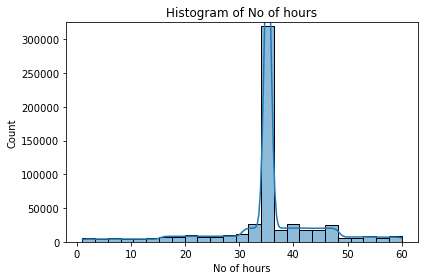

In [15]:
# Assuming df2['No of hours'] contains the relevant data.
numeric_columns = df2['No of hours']
columns_to_plot = numeric_columns

# Plot the histogram
plt.figure(figsize=(6, 4))
sns.histplot(columns_to_plot, kde=True, bins=25)  
plt.title('Histogram of No of hours')

# Adjust the y-axis range based on the data frequency
plt.ylim(0, 325000)  # Adjusted y-axis to better reflect data concentration
plt.xlabel('No of hours')
plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()


#### 5.2 IQR Method to Identify Outliers

In [16]:
# Calculate the Q1 (25th percentile) and Q3 (75th percentile) for 'No of hours'
Q1_no_hours = numeric_columns.quantile(0.25)
Q3_no_hours = numeric_columns.quantile(0.75)

# Calculate the Interquartile Range (IQR) for 'No of hours'
IQR_no_hours = Q3_no_hours - Q1_no_hours

# Define the lower and upper bounds for outliers
lower_bound_no_hours = Q1_no_hours - 1.5 * IQR_no_hours
upper_bound_no_hours = Q3_no_hours + 1.5 * IQR_no_hours

# Identify outliers in the 'No of hours' column
outliers_no_hours = numeric_columns[(numeric_columns < lower_bound_no_hours) |
                                    (numeric_columns > upper_bound_no_hours)]

# Display the outlier values for 'No of hours'
print(f'Lower bound for No of hours is {lower_bound_no_hours}')
print(f'Upper bound for No of hours is {upper_bound_no_hours}')
print(f'Unique outliers for No of hours are {outliers_no_hours.unique()}')

Lower bound for No of hours is 34.086972129878575
Upper bound for No of hours is 37.14781672207286
Unique outliers for No of hours are [ 2.  1. 10.  3.  8. 15. 14. 12.  7.  9.  6. 13.  4. 11.  5. 20. 26. 29.
 25. 19. 27. 23. 21. 22. 24. 18. 28. 30. 16. 17. 32. 40. 42. 43. 47. 31.
 38. 44. 34. 33. 46. 45. 48. 41. 39. 57. 55. 51. 56. 59. 58. 52. 60. 50.
 53. 54. 49.]


#### 5.3 Visual Representation of Outliers

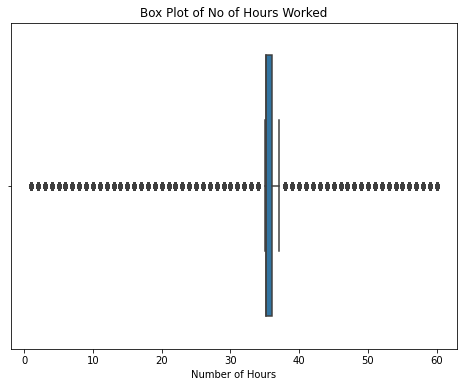

In [17]:
# Box Plot for 'No of hours'
plt.figure(figsize=(8, 6))
sns.boxplot(numeric_columns)
plt.title('Box Plot of No of Hours Worked')
plt.xlabel('Number of Hours')
plt.show()

<font color="green"> *We don't need to consider for outliers in the 'No of hours' column because all the values between 1 and 60 represent normal and valid working hours. Since these values are legitimate and reflect real-world variations in people's work schedules, considering them as outliers would risk removing meaningful data and could negatively affect your analysis.*

### 6. Data Visualization

#### 6.1 Univariate Analysis

**Histogram**

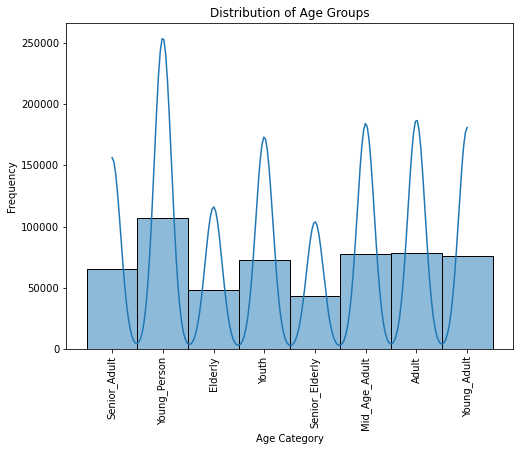

In [18]:
# Histogram
plt.figure(figsize=(8,6))
sns.histplot(df2['Age_Group_Category'], bins=8, kde=True)
plt.title('Distribution of Age Groups')
plt.xlabel('Age Category')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

**Bar Plot of Gender**

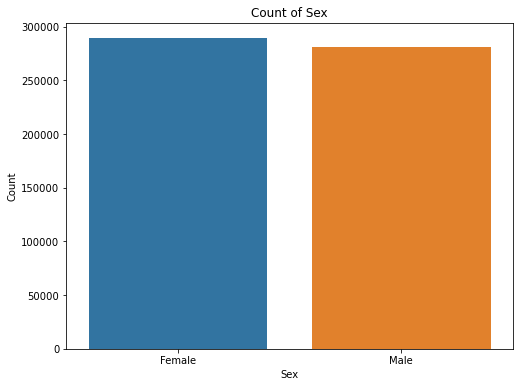

In [19]:
# Bar Plot
plt.figure(figsize=(8,6))
sns.countplot(x='Sex', data=df2)
plt.title('Count of Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

#### 6.2 Bivariate Analysis

**Scatter Plot of Age Category vs. No of Hours with Gender**

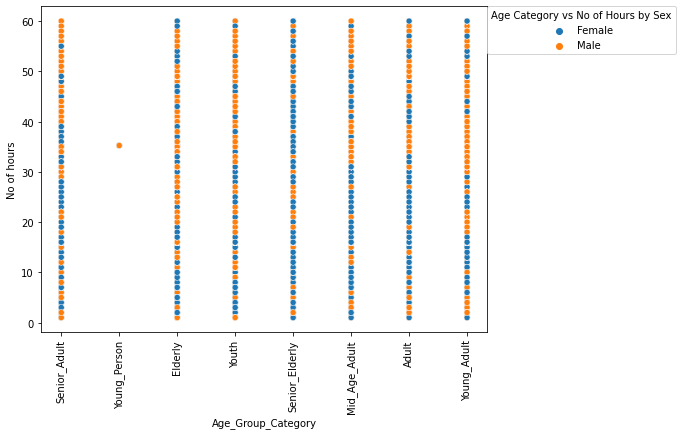

In [20]:
# Plot 2: Relation between Age and No of Hours with gender as hue
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Age_Group_Category', y='No of hours', hue='Sex', data=df2)
# plt.title('Age Category vs No of Hours by gender')
plt.xticks(rotation=90)
plt.legend(title='Age Category vs No of Hours by Sex', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)
plt.show()

**Bar Plot of Marital Status vs. Approximated Social Grade**

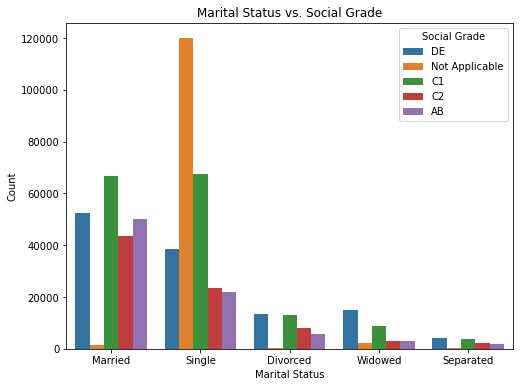

In [21]:
# Grouped Bar Plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Marital Status', hue='Social_Grade_Category', data=df2)
plt.title('Marital Status vs. Social Grade')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Social Grade')
plt.show()

In [22]:
# Filter out rows where 'Industry', 'Occupation', 'Country of Birth', and 'Ethnic Group' are 'Not Applicable' for the visualization

df_filtered_industry = df2[df2['Industry'] != 'Not Applicable']

# Filter out rows where 'Occupation' is 'Not Applicable'
df_filtered_occupation = df2[df2['Occupation'] != 'Not Applicable']

# Filter out rows where 'Ethnic Group' is 'Not Applicable'
df_filtered_ethnic_group = df2[df2['Ethnic Group'] != 'Not Applicable']

# Filter out rows where 'Country of Birth' is 'Not Applicable'
df_filtered_country_birth = df2[df2['Country of Birth'] != 'Not Applicable']

**Box Plot of Relationship between Industry, No of Hours, and Approximated Social Grade**

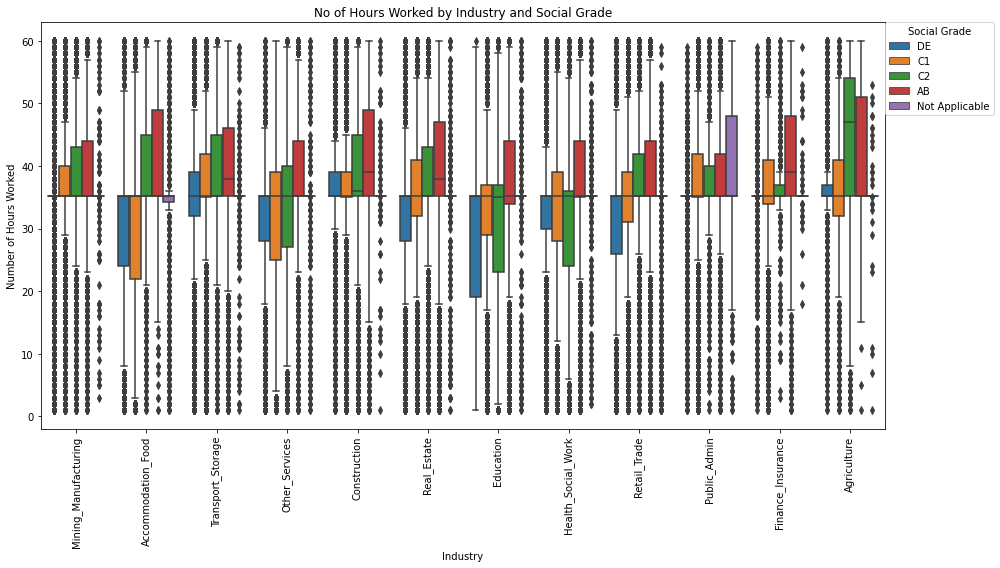

In [23]:
# Set the figure size
plt.figure(figsize=(14,8))

# Create the box plot
sns.boxplot(x='Industry', y='No of hours', hue='Social_Grade_Category', data=df_filtered_industry)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Set plot title and labels
plt.title('No of Hours Worked by Industry and Social Grade')
plt.xlabel('Industry')
plt.ylabel('Number of Hours Worked')

# Adjust the legend to be at the top right, outside the plot
plt.legend(title='Social Grade', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)

# Show the plot
plt.tight_layout()
plt.show()

**Box Plot of Relationship between Occupation, No of Hours, and Approximated Social Grade**

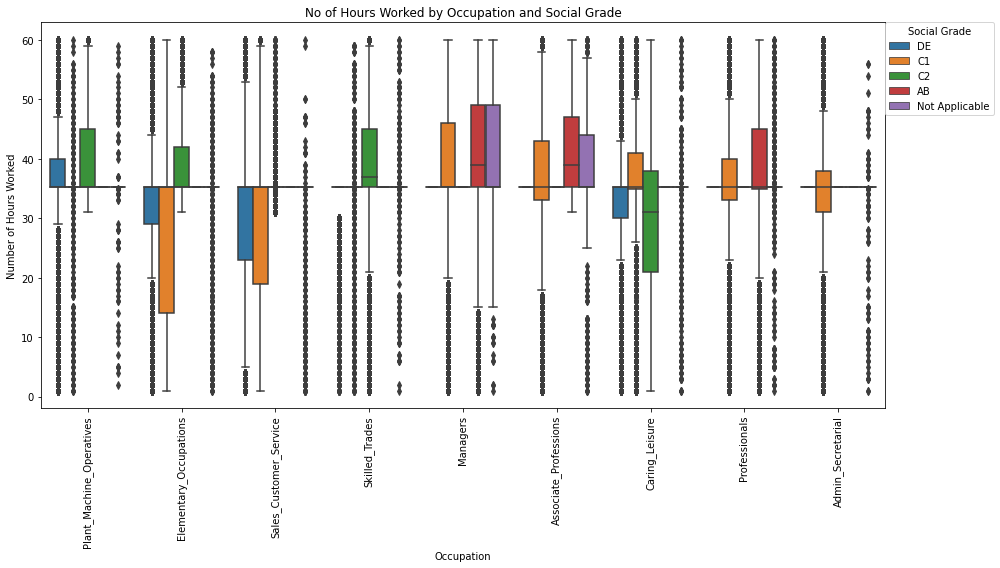

In [24]:
# Set the figure size
plt.figure(figsize=(14, 8))

# Create the box plot
sns.boxplot(x='Occupation', y='No of hours', hue='Social_Grade_Category', data=df_filtered_occupation)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Set plot title and labels
plt.title('No of Hours Worked by Occupation and Social Grade')
plt.xlabel('Occupation')
plt.ylabel('Number of Hours Worked')

# Adjust the legend to be at the top right, outside the plot
plt.legend(title='Social Grade', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)

# Show the plot
plt.tight_layout()
plt.show()

**Count Plot of Ethnic Group vs. Health Status**

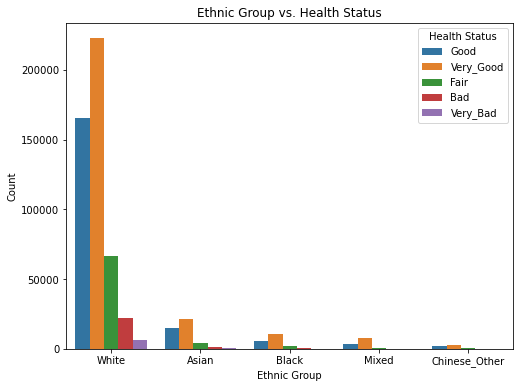

In [25]:
# Count Plot
plt.figure(figsize=(8,6))
sns.countplot(x='Ethnic Group', hue='Health_Category', data= df_filtered_ethnic_group)
plt.title('Ethnic Group vs. Health Status')
plt.xlabel('Ethnic Group')
plt.ylabel('Count')
plt.legend(title='Health Status')
plt.show()

**Heat Map for Relationship between Country of Birth, No of Hours, and Approximated Social Grade**

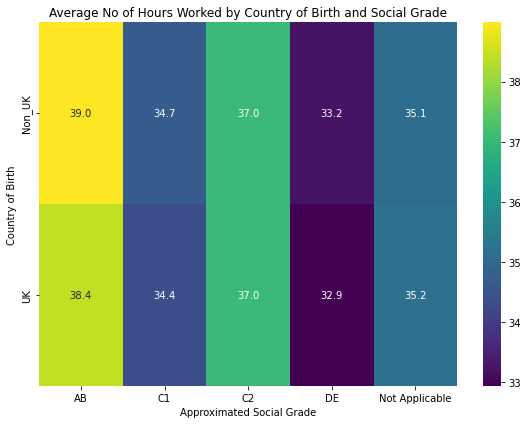

In [26]:
# Calculate mean hours worked
mean_hours_country = df_filtered_country_birth.groupby(['Country of Birth', 'Social_Grade_Category'])['No of hours'].mean().reset_index()

# Pivot the data
mean_hours_pivot = mean_hours_country.pivot(index='Country of Birth', columns='Social_Grade_Category', values='No of hours')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(mean_hours_pivot, annot=True, fmt=".1f", cmap='viridis')

plt.title('Average No of Hours Worked by Country of Birth and Social Grade')
plt.xlabel('Approximated Social Grade')
plt.ylabel('Country of Birth')

plt.tight_layout()
plt.show()

### 8. Correlation Matrix & Heatmap

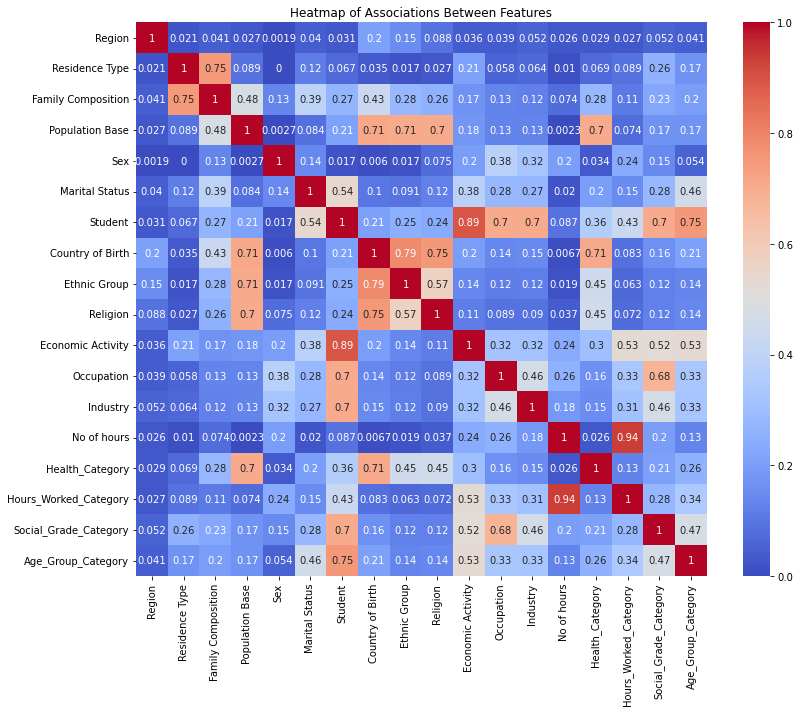

In [27]:
# Function to compute Cramér's V for two categorical variables
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    return np.sqrt(phi2corr / min(k - 1, r - 1))

# Function to compute correlation ratio for numerical vs categorical variables
def correlation_ratio(cat_col, num_col):
    fcat, _ = pd.factorize(cat_col)
    y_total_mean = np.mean(num_col)
    numerator = np.sum([len(num_col[fcat == i]) * (np.mean(num_col[fcat == i]) - y_total_mean) ** 2 for i in np.unique(fcat)])
    denominator = np.sum((num_col - y_total_mean) ** 2)
    return np.sqrt(numerator / denominator) if denominator != 0 else 0

# Identify categorical and numerical columns
categorical_cols = df2.select_dtypes(include=['object', 'category']).columns
numerical_cols = df2.select_dtypes(include=['number']).columns

# Initialize an empty DataFrame to store associations
association_matrix = pd.DataFrame(index=df2.columns, columns=df2.columns)

# Calculate associations
for col1 in df2.columns:
    for col2 in df2.columns:
        if col1 == col2:
            association_matrix.loc[col1, col2] = 1.0
        elif col1 in categorical_cols and col2 in categorical_cols:
            association_matrix.loc[col1, col2] = cramers_v(df2[col1], df2[col2])
        elif col1 in numerical_cols and col2 in numerical_cols:
            association_matrix.loc[col1, col2], _ = pearsonr(df2[col1], df2[col2])
        else:
            if col1 in categorical_cols:
                association_matrix.loc[col1, col2] = correlation_ratio(df2[col1], df2[col2])
            else:
                association_matrix.loc[col1, col2] = correlation_ratio(df2[col2], df2[col1])

# Convert to float and plot the heatmap
association_matrix = association_matrix.astype(float)

plt.figure(figsize=(12, 10))
sns.heatmap(association_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Heatmap of Associations Between Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


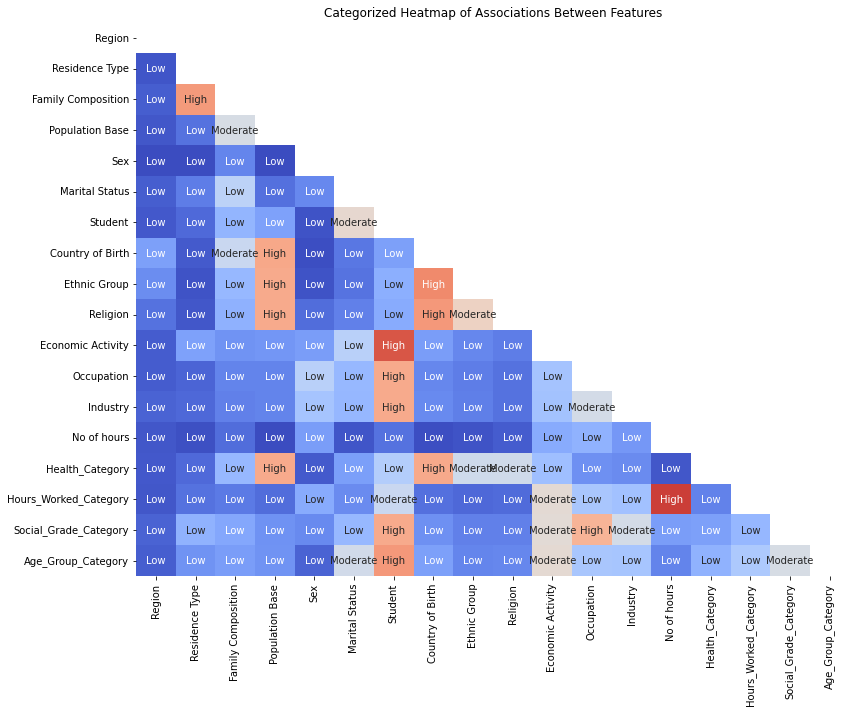

In [28]:
# Apply the categorization function to each value in the association matrix
categorized_matrix = association_matrix.applymap(lambda x: 'High' if abs(x) > 0.6 else ('Moderate' if abs(x) > 0.4 else 'Low'))

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(association_matrix, dtype=bool))

# Plot the categorized heatmap with the mask
plt.figure(figsize=(12, 10))
sns.heatmap(association_matrix, annot=categorized_matrix, fmt='', mask=mask, cmap='coolwarm', vmin=0, vmax=1, cbar=False)
plt.title("Categorized Heatmap of Associations Between Features")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 7. Label Encoding

In [29]:
# Nominal columns
nominal_columns = ['Region', 'Residence Type', 'Family Composition', 'Population Base',
                   'Sex', 'Marital Status', 'Student', 'Country of Birth', 'Ethnic Group',
                   'Religion', 'Economic Activity', 'Occupation', 'Industry']

# Ordinal columns
ordinal_columns = ['Age_Group_Category', 'Health_Category', 'Hours_Worked_Category', 'Social_Grade_Category']

# Create a copy of df2 for encoded transformations
df3 = df2.copy()

In [30]:
# Label encoding for ordinal columns in df3
le = LabelEncoder()
for col in ordinal_columns:
    df3[col] = le.fit_transform(df3[col])

In [31]:
# One-hot encoding for nominal columns in df3
df3 = pd.get_dummies(df3, columns=nominal_columns, drop_first=True)

**Remove unwanted Column**

In [32]:
# Remove columns ending with 'Not Applicable' in df3
df3 = df3.loc[:, ~df3.columns.str.endswith('Not Applicable')]

### 8. Feature Importance

In [33]:
# Function to perform RFE
def perform_rfe(X, y, estimator, n_features_to_select=15):
    rfe_selector = RFE(estimator=estimator, n_features_to_select=n_features_to_select)
    rfe_selector.fit(X, y)
    return rfe_selector

# Log the start time
start_time = datetime.now()
print(f"Process started at: {start_time}")

# Prepare the data for classification and regression
X_class = df3.drop(['Social_Grade_Category'], axis=1)
y_class = df3['Social_Grade_Category']

X_reg = df3.drop(['No of hours'], axis=1)
y_reg = df3['No of hours']

# Pre-select features using SelectKBest for both tasks
def select_kbest_features(X, y, k=30):
    kbest = SelectKBest(score_func=f_classif, k=k)
    X_selected = kbest.fit_transform(X, y)
    selected_feature_names = X.columns[kbest.get_support()]
    return X_selected, selected_feature_names

X_class_selected, selected_class_features = select_kbest_features(X_class, y_class)
X_reg_selected, selected_reg_features = select_kbest_features(X_reg, y_reg)

# RFE for classification
print("Performing RFE for 'Social_Grade_Category' prediction...")
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class_selected, y_class, test_size=0.2, random_state=42)
rf_class = RandomForestClassifier(n_estimators=30, random_state=42,n_jobs=-1)
rfe_class = perform_rfe(X_train_class, y_train_class, rf_class)

# RFE for regression
print("Performing RFE for 'No of hours' prediction...")
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg_selected, y_reg, test_size=0.2, random_state=42)
rf_reg = RandomForestRegressor(n_estimators=30, random_state=42,n_jobs=-1)
rfe_reg = perform_rfe(X_train_reg, y_train_reg, rf_reg)

# Get selected feature names
selected_features_class = selected_class_features[rfe_class.support_]
selected_features_reg = selected_reg_features[rfe_reg.support_]

# Train Random Forest on selected features
rf_class.fit(X_train_class[:, rfe_class.support_], y_train_class)
rf_reg.fit(X_train_reg[:, rfe_reg.support_], y_train_reg)

# Feature Importance for classification
print("\nFeature Importance for 'Social_Grade_Category' prediction (Top 15 Features):")
feature_importance_class = pd.Series(rf_class.feature_importances_, index=selected_features_class).sort_values(ascending=False)
print(feature_importance_class)

# Feature Importance for regression
print("\nFeature Importance for 'No of hours' prediction (Top 15 Features):")
feature_importance_reg = pd.Series(rf_reg.feature_importances_, index=selected_features_reg).sort_values(ascending=False)
print(feature_importance_reg)

# Log the end time
end_time = datetime.now()
print(f"Process ended at: {end_time}")

# Print the total time taken
print(f"Total time taken: {end_time - start_time}")


Process started at: 2024-11-11 21:51:07.146563
Performing RFE for 'Social_Grade_Category' prediction...
Performing RFE for 'No of hours' prediction...

Feature Importance for 'Social_Grade_Category' prediction (Top 15 Features):
Age_Group_Category                     0.200984
Occupation_Professionals               0.106338
Occupation_Skilled_Trades              0.091295
Student_Yes                            0.078485
Occupation_Elementary_Occupations      0.076747
No of hours                            0.063854
Hours_Worked_Category                  0.054711
Marital Status_Single                  0.049312
Residence Type_Non_Comm_Est            0.045816
Occupation_Plant_Machine_Operatives    0.044007
Economic Activity_Inactive_Student     0.043840
Occupation_Associate_Professions       0.038276
Occupation_Sales_Customer_Service      0.037475
Occupation_Caring_Leisure              0.036137
Occupation_Managers                    0.032722
dtype: float64

Feature Importance for 'No of hours

### 8.1. Select Top Features and Targets for Classification and Regression Tasks

In [34]:
# Select top features for classification
X_classification_top = df3[feature_importance_class.index]
# Select top features for regression
X_regression_top = df3[feature_importance_reg.index]

### 9. Split the Dataset into Training Data & Test Data

In [35]:
# Targets for classification and regression
y_classification = df3['Social_Grade_Category']  # Target for classification
y_regression = df3['No of hours']  # Target for regression

In [36]:
# Splitting the data for classification with stratified sampling
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification_top, y_classification, test_size=0.2, random_state=42, stratify=y_classification)

# Splitting the data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression_top, y_regression, test_size=0.2, random_state=42)

### 10. Check Class Imbalance for Classification

In [37]:
# Check for class imbalance in the classification target variable
class_distribution = y_train_class.value_counts()
print(class_distribution)

1    127714
4     99282
3     98991
0     65856
2     63949
Name: Social_Grade_Category, dtype: int64


**Calculate Each Class Percentage and Plot**

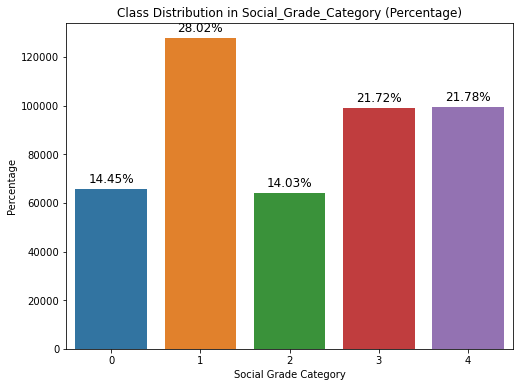

In [38]:
# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))

# Calculate the percentage of each class
class_proportion = y_train_class.value_counts(normalize=True) * 100

# Plot with percentage
ax = sns.countplot(x=y_train_class)

# Annotate each bar with the percentage
for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(y_train_class):.2f}%'  # Calculate percentage
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.title('Class Distribution in Social_Grade_Category (Percentage)')
plt.xlabel('Social Grade Category')
plt.ylabel('Percentage')
plt.xticks(rotation=0)  # Rotate the labels for readability if needed
plt.show()

#### 10.1 Handling Class Imbalance

In [39]:
# Log the start time
start_time = datetime.now()
print(f"Process started at: {start_time}")

# Apply SMOTE with all CPU cores (n_jobs=-1)
smote = SMOTE(random_state=42, n_jobs=-1)  # n_jobs=-1 uses all available cores

# Resample the data using SMOTE
X_train_class_balanced, y_train_class_balanced = smote.fit_resample(X_train_class, y_train_class)

# Log the end time
end_time = datetime.now()
print(f"Process ended at: {end_time}")

# Calculate and display the time taken for the process
print(f"Total time taken: {end_time - start_time}")

# Print original and balanced class distribution
print(f"Original class distribution:\n{y_train_class.value_counts()}")
print(f"Balanced class distribution:\n{y_train_class_balanced.value_counts()}")


Process started at: 2024-11-11 21:56:32.811577
Process ended at: 2024-11-11 22:00:59.805441
Total time taken: 0:04:26.993864
Original class distribution:
1    127714
4     99282
3     98991
0     65856
2     63949
Name: Social_Grade_Category, dtype: int64
Balanced class distribution:
0    127714
2    127714
1    127714
4    127714
3    127714
Name: Social_Grade_Category, dtype: int64


### 11. Feature Scaling

In [40]:
# List of numeric columns to scale (e.g., 'No of hours')
num_col = ['No of hours']

# Identify the numeric columns present in your training data
num_col_in_data = [col for col in X_train_class_balanced.columns if col in num_col]

# Print the numeric columns that will be scaled
print("Numeric columns to scale:", num_col_in_data)

# Proceed with scaling if there are numeric columns
if num_col_in_data:
    # Initialize the MinMaxScaler
    scaler = StandardScaler()

    # Fit the scaler on the numeric columns of the training data
    scaler.fit(X_train_class_balanced[num_col_in_data])

    # Define new variables for scaled data (using .copy() for data integrity)
    X_train_class_balanced_scaled = X_train_class_balanced.copy()
    X_test_class_scaled = X_test_class.copy()

    # Apply the scaling to the numeric columns in the training data
    X_train_class_balanced_scaled[num_col_in_data] = scaler.transform(
        X_train_class_balanced_scaled[num_col_in_data]
    )

    # Apply the same scaling to the numeric columns in the test data
    X_test_class_scaled[num_col_in_data] = scaler.transform(
        X_test_class_scaled[num_col_in_data]
    )
else:
    print("No numeric columns to scale. Skipping scaling step.")
    # Assign the variables directly
    X_train_class_balanced_scaled = X_train_class_balanced.copy()
    X_test_class_scaled = X_test_class.copy()

Numeric columns to scale: ['No of hours']


### 12. Classification

In [41]:
# Logistic Regression with class weights
logreg = LogisticRegression(multi_class='ovr', max_iter=500) #, class_weight=class_weight_dict)
logreg.fit(X_train_class_balanced_scaled, y_train_class_balanced)

# Decision Tree with class weights
dtree = DecisionTreeClassifier(random_state=42) #, class_weight=class_weight_dict)
dtree.fit(X_train_class_balanced_scaled, y_train_class_balanced)

# Random Forest with class weights
rf = RandomForestClassifier(random_state=42) #, class_weight=class_weight_dict)
rf.fit(X_train_class_balanced_scaled, y_train_class_balanced)

# XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train_class_balanced_scaled, y_train_class_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [42]:
# Logistic Regression
y_pred_logreg = logreg.predict(X_test_class_scaled)
y_pred_logreg_proba = logreg.predict_proba(X_test_class_scaled)  # For multi-class, keep full probability estimates
accuracy_logreg = accuracy_score(y_test_class, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test_class, y_pred_logreg_proba, multi_class='ovr')  # Specify multi_class
print(f'Logistic Regression Accuracy: {accuracy_logreg}')
print(f'Logistic Regression ROC AUC Score: {roc_auc_logreg}')
print(classification_report(y_test_class, y_pred_logreg))

# Decision Tree Classifier
y_pred_dtree = dtree.predict(X_test_class_scaled)
y_pred_dtree_proba = dtree.predict_proba(X_test_class_scaled)
accuracy_dtree = accuracy_score(y_test_class, y_pred_dtree)
roc_auc_dtree = roc_auc_score(y_test_class, y_pred_dtree_proba, multi_class='ovr')
print(f'Decision Tree Accuracy: {accuracy_dtree}')
print(f'Decision Tree ROC AUC Score: {roc_auc_dtree}')
print(classification_report(y_test_class, y_pred_dtree))

# Random Forest Classifier
y_pred_rf = rf.predict(X_test_class_scaled)
y_pred_rf_proba = rf.predict_proba(X_test_class_scaled)
accuracy_rf = accuracy_score(y_test_class, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test_class, y_pred_rf_proba, multi_class='ovr')
print(f'Random Forest Accuracy: {accuracy_rf}')
print(f'Random Forest ROC AUC Score: {roc_auc_rf}')
print(classification_report(y_test_class, y_pred_rf))

# XGBoost
y_pred_xgb = xgb.predict(X_test_class_scaled)
y_pred_xgb_proba = xgb.predict_proba(X_test_class_scaled)
accuracy_xgb = accuracy_score(y_test_class, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test_class, y_pred_xgb_proba, multi_class='ovr')

print(f'XGBoost Accuracy: {accuracy_xgb}')
print(f'XGBoost ROC AUC Score: {roc_auc_xgb}')
print(classification_report(y_test_class, y_pred_xgb))

Logistic Regression Accuracy: 0.7496928423491417
Logistic Regression ROC AUC Score: 0.9301162213432821
              precision    recall  f1-score   support

           0       0.67      0.81      0.73     16464
           1       0.79      0.65      0.71     31928
           2       0.61      0.69      0.65     15987
           3       0.72      0.64      0.68     24748
           4       0.89      0.99      0.94     24821

    accuracy                           0.75    113948
   macro avg       0.73      0.76      0.74    113948
weighted avg       0.75      0.75      0.75    113948

Decision Tree Accuracy: 0.7837259100642399
Decision Tree ROC AUC Score: 0.9554390983753592
              precision    recall  f1-score   support

           0       0.67      0.82      0.74     16464
           1       0.84      0.67      0.75     31928
           2       0.66      0.72      0.69     15987
           3       0.70      0.74      0.72     24748
           4       0.99      0.99      0.99   

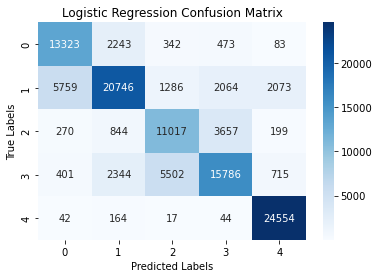

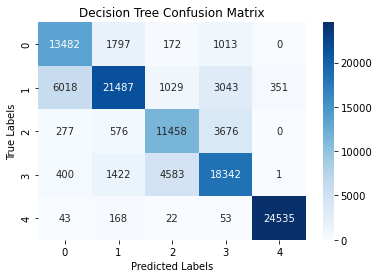

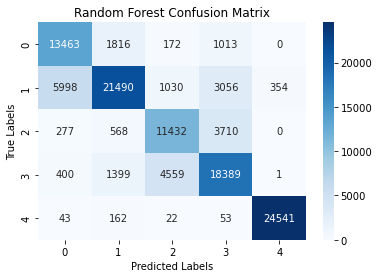

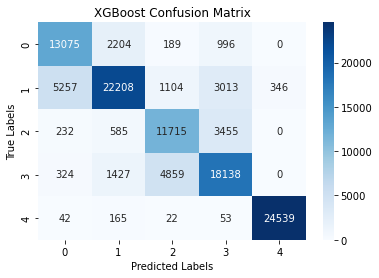

In [43]:
# Get the class labels (ensure they are sorted consistently)
class_names = sorted(y_test_class.unique())

# Logistic Regression Confusion Matrix
cm_logreg = confusion_matrix(y_test_class, y_pred_logreg)
plt.figure(figsize=(6,4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Decision Tree Classifier Confusion Matrix
cm_dtree = confusion_matrix(y_test_class, y_pred_dtree)
plt.figure(figsize=(6,4))
sns.heatmap(cm_dtree, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Random Forest Classifier Confusion Matrix
cm_rf = confusion_matrix(y_test_class, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# XGBoost Confusion Matrix
cm_xgb = confusion_matrix(y_test_class, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Confusion Matrices with Percentages

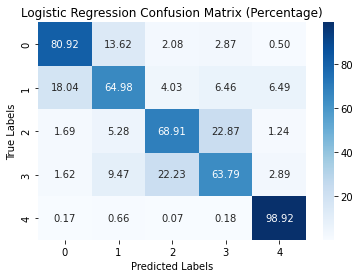

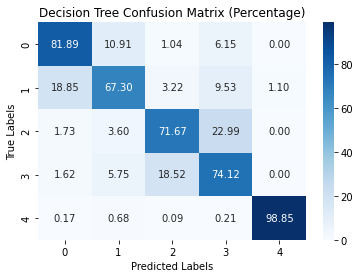

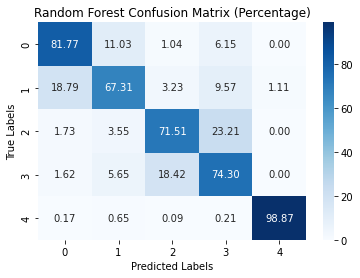

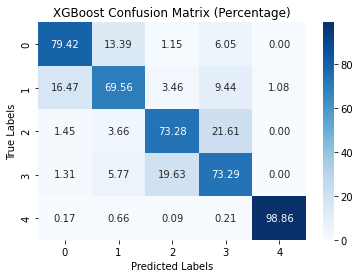

In [44]:
# Function to plot confusion matrix as percentage
def plot_confusion_matrix_percentage(cm, class_names, title):
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Get the class labels (ensure they are sorted consistently)
class_names = sorted(y_test_class.unique())

# Logistic Regression Confusion Matrix
cm_logreg = confusion_matrix(y_test_class, y_pred_logreg)
plot_confusion_matrix_percentage(cm_logreg, class_names, 'Logistic Regression Confusion Matrix (Percentage)')

# Decision Tree Classifier Confusion Matrix
cm_dtree = confusion_matrix(y_test_class, y_pred_dtree)
plot_confusion_matrix_percentage(cm_dtree, class_names, 'Decision Tree Confusion Matrix (Percentage)')

# Random Forest Classifier Confusion Matrix
cm_rf = confusion_matrix(y_test_class, y_pred_rf)
plot_confusion_matrix_percentage(cm_rf, class_names, 'Random Forest Confusion Matrix (Percentage)')

# XGBoost Confusion Matrix
cm_xgb = confusion_matrix(y_test_class, y_pred_xgb)
plot_confusion_matrix_percentage(cm_xgb, class_names, 'XGBoost Confusion Matrix (Percentage)')


### Receiver Operating Characteristic (ROC) Curve

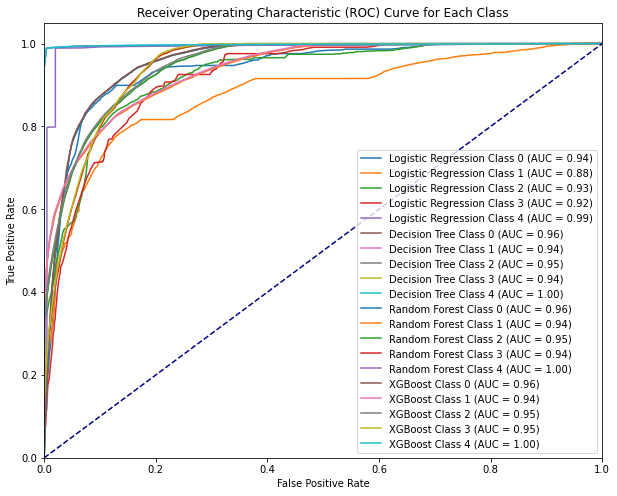

In [45]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output for multi-class ROC analysis
y_test_binarized = label_binarize(y_test_class, classes=np.unique(y_test_class))
n_classes = y_test_binarized.shape[1]

# Initialize the plot
plt.figure(figsize=(10, 8))

# Logistic Regression ROC Curve for each class
fpr_logreg = dict()
tpr_logreg = dict()
roc_auc_logreg = dict()
for i in range(n_classes):
    fpr_logreg[i], tpr_logreg[i], _ = roc_curve(y_test_binarized[:, i], y_pred_logreg_proba[:, i])
    roc_auc_logreg[i] = auc(fpr_logreg[i], tpr_logreg[i])
    plt.plot(fpr_logreg[i], tpr_logreg[i], label=f'Logistic Regression Class {i} (AUC = {roc_auc_logreg[i]:.2f})')

# Decision Tree ROC Curve for each class
fpr_dtree = dict()
tpr_dtree = dict()
roc_auc_dtree = dict()
for i in range(n_classes):
    fpr_dtree[i], tpr_dtree[i], _ = roc_curve(y_test_binarized[:, i], y_pred_dtree_proba[:, i])
    roc_auc_dtree[i] = auc(fpr_dtree[i], tpr_dtree[i])
    plt.plot(fpr_dtree[i], tpr_dtree[i], label=f'Decision Tree Class {i} (AUC = {roc_auc_dtree[i]:.2f})')

# Random Forest ROC Curve for each class
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_binarized[:, i], y_pred_rf_proba[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])
    plt.plot(fpr_rf[i], tpr_rf[i], label=f'Random Forest Class {i} (AUC = {roc_auc_rf[i]:.2f})')

# XGBoost ROC Curve for each class
fpr_xgb = dict()
tpr_xgb = dict()
roc_auc_xgb = dict()
for i in range(n_classes):
    fpr_xgb[i], tpr_xgb[i], _ = roc_curve(y_test_binarized[:, i], y_pred_xgb_proba[:, i])
    roc_auc_xgb[i] = auc(fpr_xgb[i], tpr_xgb[i])
    plt.plot(fpr_xgb[i], tpr_xgb[i], label=f'XGBoost Class {i} (AUC = {roc_auc_xgb[i]:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Dashed diagonal line (no discrimination)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc='lower right')
plt.show()


### 13. Regression

In [46]:
# Initialize models
linear_model = LinearRegression()
ridge_model = Ridge()
lasso_model = Lasso()
# Initialize non-linear models
gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
decision_tree_model = DecisionTreeRegressor()

# List of models for easy iteration
models = {
    'Linear Regression': linear_model,
    'Ridge Regression': ridge_model,
    'Lasso Regression': lasso_model,
    'Decision Tree Regression': decision_tree_model,
    'Gradient Boosting Regression': gradient_boosting_model
}

In [47]:
# Training and evaluating models
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_reg, y_train_reg)

    # Predict on the test set
    y_pred = model.predict(X_test_reg)

    # Evaluate the model
    mse = mean_squared_error(y_test_reg, y_pred)
    r2 = r2_score(y_test_reg, y_pred)

    print(f'{model_name} - MSE: {mse:.4f}, R2: {r2:.4f}')

Linear Regression - MSE: 49.6538, R2: 0.4201
Ridge Regression - MSE: 49.6538, R2: 0.4201
Lasso Regression - MSE: 51.9461, R2: 0.3934
Decision Tree Regression - MSE: 11.1114, R2: 0.8702
Gradient Boosting Regression - MSE: 10.5205, R2: 0.8771


#### 13.1 cross-validation for non-linear regression models

In [68]:
# Filter to include only non-linear models (exclude Linear, Ridge, and Lasso)
non_linear_models = {name: model for name, model in models.items() if 'Linear' not in name and 'Ridge' not in name and 'Lasso' not in name}

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store results for non-linear models
results = {}

# Loop over each non-linear model in the dictionary
for model_name, model in non_linear_models.items():
    mse_scores = []
    r2_scores = []

    # Loop over the K folds
    for train_index, test_index in kf.split(X_train_reg):
        # Use .iloc to correctly index pandas DataFrame
        X_train, X_test = X_train_reg.iloc[train_index], X_train_reg.iloc[test_index]
        y_train, y_test = y_train_reg.iloc[train_index], y_train_reg.iloc[test_index]

        # Fit the model on training data
        model.fit(X_train, y_train)

        # Predict on test data
        y_pred = model.predict(X_test)

        # Calculate MSE and R2 for the current fold
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Append the scores to the lists
        mse_scores.append(mse)
        r2_scores.append(r2)

    # Calculate and store the mean MSE and R2 across all folds for each model
    results[model_name] = {
        'Mean MSE': sum(mse_scores) / len(mse_scores),
        'Mean R2': sum(r2_scores) / len(r2_scores)
    }

# Print the results for all non-linear models
for model_name, scores in results.items():
    print(f"{model_name} - Mean MSE: {scores['Mean MSE']:.4f}, Mean R2: {scores['Mean R2']:.4f}")

Decision Tree Regression - Mean MSE: 11.2464, Mean R2: 0.8690
Gradient Boosting Regression - Mean MSE: 10.5426, Mean R2: 0.8772


### 14. Assocoation Rule Mining

**Selected 8 Most Relevant Columns:**

- Sex
- Age_Group_Category
- Marital Status
- Economic Activity
- Occupation
- Industry
- Region
- Health_Category

**Reasons for Selection:**

* Sex & Age_Group_Category: Fundamental demographic variables that can influence and be influenced by other factors.

* Marital Status: Often associated with age, economic activity, and family composition.

* Economic Activity, Occupation, & Industry: Provide insights into employment patterns and economic behavior.

* Region: Geographical factor that can affect and reflect cultural and economic differences.

* Health_Category: Health status may be associated with age, occupation, and lifestyle factors.


In [69]:
# Select the most relevant 8 columns
columns = ['Sex', 'Age_Group_Category', 'Marital Status', 'Economic Activity',
           'Occupation', 'Industry', 'Region', 'Health_Category']

In [70]:
# Create a new DataFrame with selected columns
df_association = df2[columns].copy()

In [71]:
# Handle missing values
df_association = df_association.dropna()

In [72]:
# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df_association)

# Remove columns ending with 'Not Applicable' in df3
df_encoded = df_encoded.loc[:, ~df_encoded.columns.str.endswith('Not Applicable')]

# Optionally, check the number of one-hot encoded features
print(f"Number of one-hot encoded features: {df_encoded.shape[1]}")

Number of one-hot encoded features: 60


In [73]:
pd.set_option('display.max_colwidth', None)

In [74]:
start_time_apriori = datetime.now()
print(f"Apriori algorithm started at: {start_time_apriori}")

# Generate frequent itemsets with a minimum support threshold
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Record the end time after running Apriori
end_time_apriori = datetime.now()
print(f"Apriori algorithm ended at: {end_time_apriori}")

# Calculate and print the duration
duration_apriori = end_time_apriori - start_time_apriori
print(f"Time taken for Apriori algorithm: {duration_apriori}")

Apriori algorithm started at: 2024-11-11 22:18:26.438362
Apriori algorithm ended at: 2024-11-11 22:25:24.557072
Time taken for Apriori algorithm: 0:06:58.118710


In [75]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [76]:
# Filter significant rules (adjust thresholds as needed)
significant_rules = rules[(rules['confidence'] > 0.7) & (rules['lift'] > 1)]
significant_rules = significant_rules.sort_values(by='lift', ascending=False)

# Display top 10 rules
significant_rules.head(15)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8435,"(Age_Group_Category_Youth, Occupation_Sales_Customer_Service)","(Industry_Retail_Trade, Marital Status_Single)",0.019121,0.045623,0.014942,0.781439,17.128352,0.014070,4.366648
8938,"(Economic Activity_Inactive_Retired, Health_Category_Fair, Sex_Female, Marital Status_Widowed)",(Age_Group_Category_Senior_Elderly),0.014549,0.076709,0.011388,0.782724,10.203854,0.010272,4.249396
8112,"(Economic Activity_Inactive_Retired, Health_Category_Fair, Marital Status_Widowed)",(Age_Group_Category_Senior_Elderly),0.018533,0.076709,0.014426,0.778388,10.147328,0.013004,4.166253
7892,"(Industry_Construction, Economic Activity_Active_Self_Employed)","(Occupation_Skilled_Trades, Sex_Male)",0.014973,0.072122,0.010731,0.716680,9.937005,0.009651,3.275020
5025,"(Health_Category_Fair, Sex_Female, Marital Status_Widowed)",(Age_Group_Category_Senior_Elderly),0.016702,0.076709,0.012214,0.731295,9.533402,0.010933,3.436074
3142,"(Health_Category_Fair, Marital Status_Widowed)",(Age_Group_Category_Senior_Elderly),0.021424,0.076709,0.015454,0.721367,9.403976,0.013811,3.313641
5010,"(Economic Activity_Inactive_Retired, Sex_Female, Marital Status_Widowed)",(Age_Group_Category_Senior_Elderly),0.034876,0.076709,0.024882,0.713437,9.300608,0.022206,3.221953
3135,"(Economic Activity_Inactive_Retired, Marital Status_Widowed)",(Age_Group_Category_Senior_Elderly),0.044624,0.076709,0.031795,0.712516,9.288594,0.028372,3.211624
7889,"(Industry_Construction, Economic Activity_Active_Self_Employed, Sex_Male)",(Occupation_Skilled_Trades),0.014252,0.085207,0.010731,0.752956,8.836752,0.009517,3.702950
4624,"(Industry_Construction, Economic Activity_Active_Self_Employed)",(Occupation_Skilled_Trades),0.014973,0.085207,0.010940,0.730629,8.574730,0.009664,3.396039


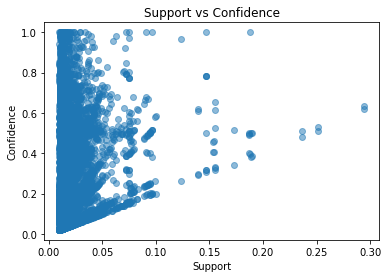

In [77]:
# Visualize support vs confidence
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence')
plt.show()

### 15. Clustering

In [78]:
columns_clustering = [
    'Age_Group_Category',
    'Health_Category',
    'Economic Activity',
    'Social_Grade_Category'
]

In [79]:
# Step 1: Take a subset of the dataset (10,000 records)
df_clustering_sample = df2[columns_clustering].sample(n=10000, random_state=42)

In [80]:
# Step 1: Data Preprocessing - handle '-9' values by imputing or dropping if appropriate
df_clustering = df_clustering_sample.replace(-9, np.nan).dropna()

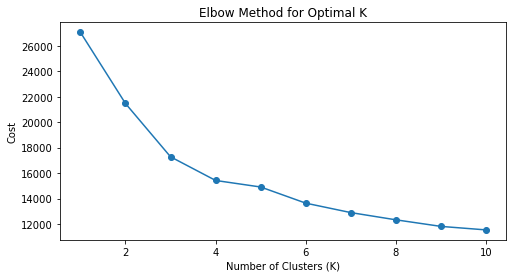

In [81]:
# Define range of K values and compute the cost for each (Elbow Method)
k_values = range(1, 11)
costs = []

for k in k_values:
    kmodes = KModes(n_clusters=k, init='Cao', n_init=5, random_state=42)
    kmodes.fit(df_clustering)
    costs.append(kmodes.cost_)

# Plot cost to visualize the Elbow
plt.figure(figsize=(8, 4))
plt.plot(k_values, costs, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cost')
plt.show()


In [82]:
# Determine optimal_k based on the Elbow plot (e.g., set manually here)
optimal_k = 4 

In [83]:
# Step 3: Apply K-Modes clustering with the optimal K
kmodes = KModes(n_clusters=optimal_k, init='Cao', n_init=5, random_state=42)
kmodes_labels = kmodes.fit_predict(df_clustering)
# Add K-Modes cluster labels
df_clustering['K-Modes Cluster'] = kmodes_labels

In [84]:
# Calculate Silhouette Score for K-Modes
df_encoded = pd.get_dummies(df_clustering)  # One-hot encode for Silhouette calculation
silhouette_kmodes = silhouette_score(df_encoded, kmodes_labels)
print(f"K-Modes Silhouette Score: {silhouette_kmodes}")

K-Modes Silhouette Score: 0.3189948691184485


In [85]:
# Step 3: Apply Hierarchical Clustering with Hamming Distance
# Compute pairwise distances using Hamming distance
distance_matrix = pairwise_distances(df_encoded, metric='hamming')

# Apply Agglomerative Clustering with the precomputed distance matrix
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, affinity='precomputed', linkage='average')
hierarchical_labels = hierarchical.fit_predict(distance_matrix)

# Add Hierarchical cluster labels
df_clustering['Hierarchical Cluster'] = hierarchical_labels

# Calculate Silhouette Score for Hierarchical Clustering
silhouette_hierarchical = silhouette_score(distance_matrix, hierarchical_labels, metric="precomputed")
print(f"Hierarchical Clustering Silhouette Score: {silhouette_hierarchical}")

Hierarchical Clustering Silhouette Score: 0.38966401635982667


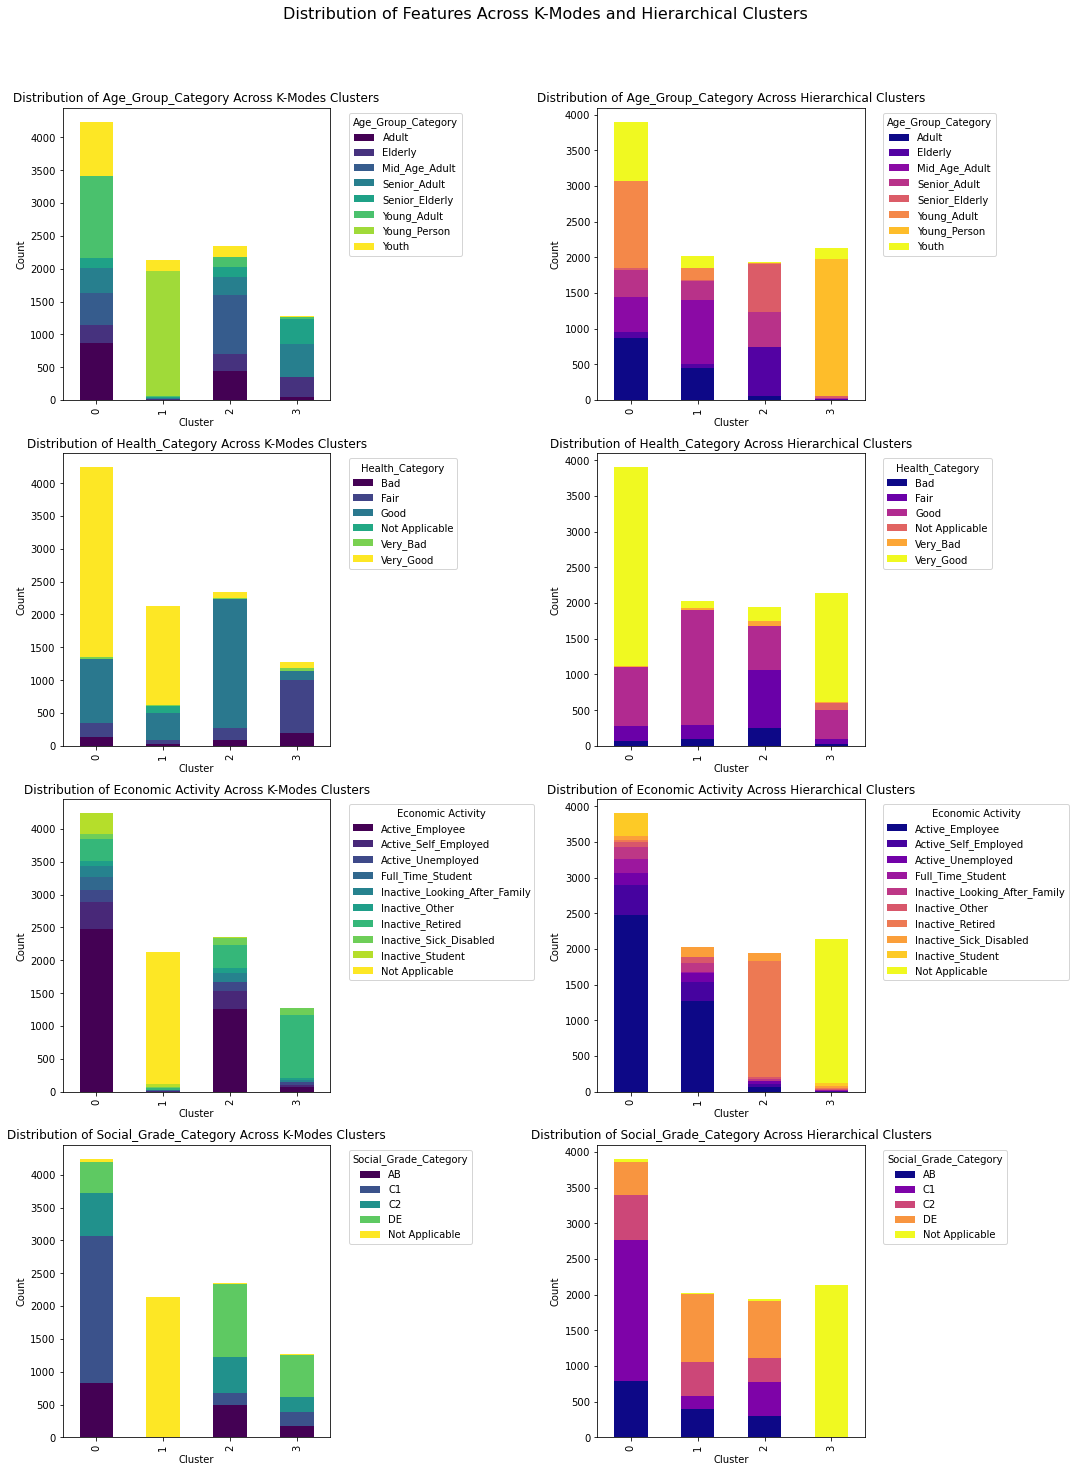

In [86]:
# Visualize Cluster Composition for K-Modes and Hierarchical Clustering in Subplots
fig, axes = plt.subplots(len(columns_clustering), 2, figsize=(15, 20))
fig.suptitle("Distribution of Features Across K-Modes and Hierarchical Clusters", fontsize=16, y=1.02)

# Loop through each column and create subplots for K-Modes and Hierarchical Clustering side by side
for i, column in enumerate(columns_clustering):
    # K-Modes Clustering Plot
    cluster_counts_kmodes = df_clustering.groupby(['K-Modes Cluster', column]).size().unstack()
    cluster_counts_kmodes.plot(kind='bar', stacked=True, colormap='viridis', ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {column} Across K-Modes Clusters')
    axes[i, 0].set_xlabel('Cluster')
    axes[i, 0].set_ylabel('Count')
    axes[i, 0].legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Hierarchical Clustering Plot
    cluster_counts_hierarchical = df_clustering.groupby(['Hierarchical Cluster', column]).size().unstack()
    cluster_counts_hierarchical.plot(kind='bar', stacked=True, colormap='plasma', ax=axes[i, 1])
    axes[i, 1].set_title(f'Distribution of {column} Across Hierarchical Clusters')
    axes[i, 1].set_xlabel('Cluster')
    axes[i, 1].set_ylabel('Count')
    axes[i, 1].legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better spacing
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust top space to fit the main title
plt.show()


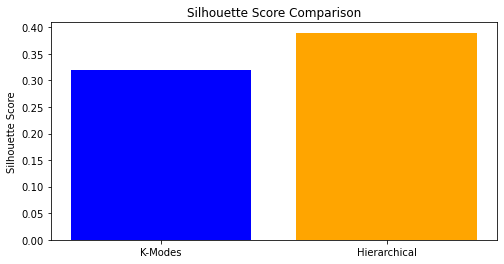

In [87]:
# Step 5: Silhouette Score Comparison Bar Plot
plt.figure(figsize=(8, 4))
plt.bar(['K-Modes', 'Hierarchical'], [silhouette_kmodes, silhouette_hierarchical], color=['blue', 'orange'])
plt.title('Silhouette Score Comparison')
plt.ylabel('Silhouette Score')
plt.show()